Consultas SQL y visualización de resultados.

In [1]:
import pandas as pd
import sqlite3
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Diccionarios: customers y products

customers = [
    {"customer_id": 1, "customer_name": "Alice", "email": "alice@example.com", "phone": "123-456-7890"},
    {"customer_id": 2, "customer_name": "Bob", "email": "bob@example.com", "phone": "234-567-8901"},
    {"customer_id": 3, "customer_name": "Charlie", "email": "charlie@example.com", "phone": "345-678-9012"}
]

products = [
    {"product_id": 1, "product_name": "Laptop", "price": 1000},
    {"product_id": 2, "product_name": "Mouse", "price": 20},
    {"product_id": 3, "product_name": "Teclado", "price": 50},
    {"product_id": 4, "product_name": "Desktop", "price": 700},
    {"product_id": 5, "product_name": "Monitor", "price": 100},
    {"product_id": 6, "product_name": "Mousepad", "price": 5},
    {"product_id": 7, "product_name": "Memoria USD", "price": 20},
    {"product_id": 8, "product_name": "Bocinas", "price": 75},
    {"product_id": 9, "product_name": "Celular", "price": 375},
    {"product_id": 10, "product_name": "Cable HDMI", "price": 15}
]

In [3]:
# Diccionario: order

orders = []

start_date = datetime(2024,4,1)
end_date = datetime(2024,6,29)
date_diff = (end_date - start_date).days

for i in range(1,101):
    order_date = start_date + timedelta(days=random.randint(0, date_diff))
    orders.append({
            "order_id":i,
            "customer_id":random.randint(1,3),
            "order_date":order_date.strftime("%Y-%m-%d"),
            "status":random.choice(["shipped","pending","delivered"])
        })

In [4]:
# Diccionario: order_items

order_items = []

order_item_id = 1
for i in range(1, 101):
    num_items = random.randint(1, 5)
    for _ in range(num_items):
        order_items.append({
            "order_item_id": order_item_id,
            "order_id": i,
            "product_id": random.randint(1, 10),
            "quantity": random.randint(1, 20)
        })
        order_item_id += 1

In [5]:
# Creación de dataframes:

customers_df = pd.DataFrame(customers)
products_df = pd.DataFrame(products)
orders_df = pd.DataFrame(orders)
order_items_df = pd.DataFrame(order_items)

In [6]:
# Creación de base de datos en la memoria (carga de dataframes):

conexion = sqlite3.connect(":memory:")
customers_df.to_sql("customers_db", conexion, index=False, if_exists="replace")
products_df.to_sql("products_db", conexion, index=False, if_exists="replace")
orders_df.to_sql("orders_db", conexion, index=False, if_exists="replace")
order_items_df.to_sql("order_items_db", conexion, index=False, if_exists="replace")

320

In [7]:
# Consulta No. 1:

"""
Visualizar campos:

1. Id de la orden (orders_db)
2. Fecha de la orden (orders_db)
3. Status de la orden (orders_db)
4. Nombre del producto (products_db)
5. Precio del producto (products_db)
6. Cantidad del producto (order_items_db)
7. Subtotal (calculada)
8. Nombre del cliete (customers_db)

"""

query_01 = """
SELECT
ord.order_id,
ord.order_date,
ord.status,
pro.product_name,
pro.price,
ord_item.quantity,
(ord_item.quantity * pro.price) AS subtotal,
cus.customer_name
FROM order_items_db AS ord_item
INNER JOIN orders_db AS ord ON ord.order_id = ord_item.order_id
INNER JOIN products_db AS pro ON pro.product_id = ord_item.product_id
INNER JOIN customers_db AS cus on cus.customer_id = ord.customer_id
"""

In [8]:
query_01_result = pd.read_sql(query_01, conexion)
query_01_result

,order_id,order_date,status,product_name,price,quantity,subtotal,customer_name
0,1,2024-06-12,pending,Cable HDMI,15,15,225,Alice
1,2,2024-04-09,pending,Laptop,1000,4,4000,Charlie
2,2,2024-04-09,pending,Laptop,1000,5,5000,Charlie
3,2,2024-04-09,pending,Bocinas,75,20,1500,Charlie
4,2,2024-04-09,pending,Celular,375,6,2250,Charlie
...,...,...,...,...,...,...,...,...
315,99,2024-04-30,delivered,Mousepad,5,11,55,Alice
316,99,2024-04-30,delivered,Cable HDMI,15,8,120,Alice
317,100,2024-05-15,pending,Laptop,1000,1,1000,Charlie
318,100,2024-05-15,pending,Bocinas,75,10,750,Charlie


In [9]:
# Creación de base de datos y carga del dataframe "query_01_result":

query_01_result.to_sql("query_01_db", conexion, index=False, if_exists="replace")

320

In [11]:
# Consulta No. 2: ventas totales o acumuladas por producto...

query_02 = """
SELECT
product_name,
SUM(subtotal) AS cumulative_sales
FROM query_01_db
GROUP BY product_name
ORDER BY cumulative_sales
"""

query_02_result = pd.read_sql(query_02, conexion)
query_02_result

,product_name,cumulative_sales
0,Mousepad,1825
1,Mouse,5720
2,Memoria USD,6520
3,Cable HDMI,7560
4,Teclado,18200
5,Bocinas,23925
6,Monitor,39500
7,Celular,99000
8,Desktop,254800
9,Laptop,281000


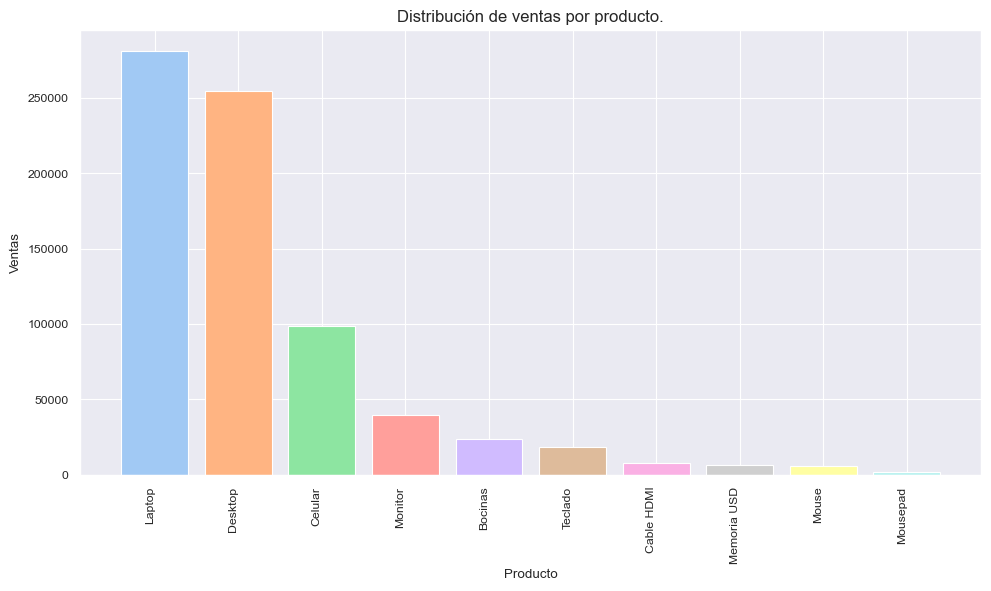

In [12]:
# Gráfico de barras: ventas por producto

query_02_result.sort_values(by="cumulative_sales", ascending=False, inplace=True)

sns.set_theme("paper")
plt.figure(figsize=(10, 6))
plt.bar(query_02_result["product_name"], query_02_result["cumulative_sales"], color=sns.color_palette("pastel"))
plt.xlabel("Producto")
plt.ylabel("Ventas")
plt.title("Distribución de ventas por producto.", fontsize=12)
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()

In [13]:
# Consulta No. 3: ventas totales o acumuladas por cliente...

query_03 = """
SELECT
customer_name,
SUM(subtotal) AS cumulative_sales
FROM query_01_db
GROUP BY customer_name
ORDER BY cumulative_sales
"""

query_03_result = pd.read_sql(query_03, conexion)
query_03_result

,customer_name,cumulative_sales
0,Alice,198450
1,Bob,241145
2,Charlie,298455


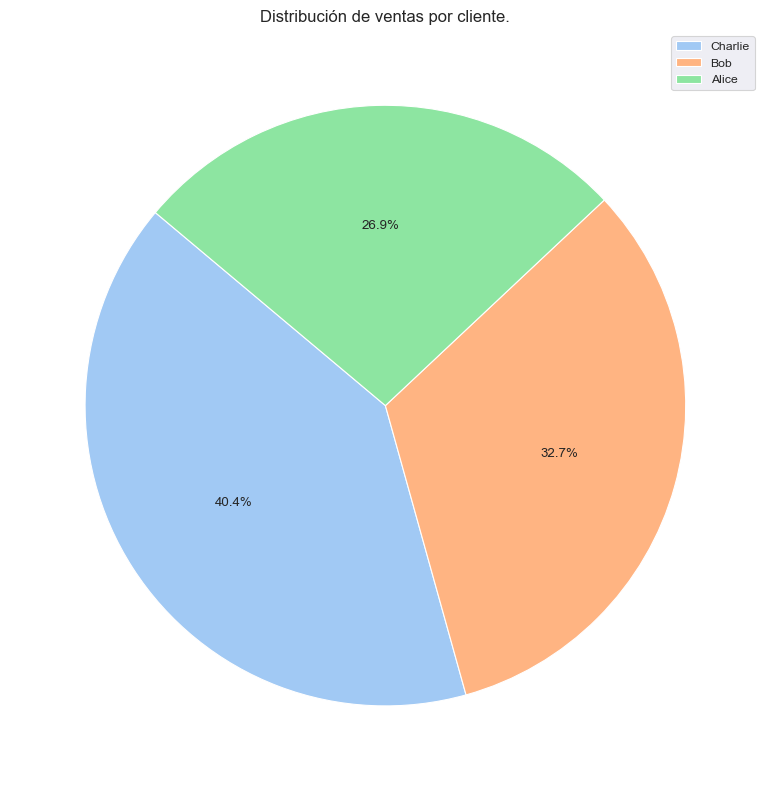

In [14]:
# Gráfico de pie: ventas por cliente

query_03_result.sort_values(by="cumulative_sales", ascending=False, inplace=True)

sns.set_theme("paper")
labels = query_03_result["customer_name"]
sizes = query_03_result["cumulative_sales"]
plt.figure(figsize=(8, 8))
plt.pie(sizes, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Distribución de ventas por cliente.", fontsize=12)
plt.legend(labels, loc="best")
plt.tight_layout()
plt.show()

In [16]:
# Consulta No. 4: ventas totales o acumuladas por fecha...

query_04 = """
SELECT
order_date,
SUM(subtotal) AS cumulative_sales
FROM query_01_db
GROUP BY order_date
ORDER BY order_date
"""

query_04_result = pd.read_sql(query_04, conexion)
query_04_result

,order_date,cumulative_sales
0,2024-04-02,800
1,2024-04-04,830
2,2024-04-05,7500
3,2024-04-07,100
4,2024-04-08,1580
5,2024-04-09,27785
6,2024-04-10,14420
7,2024-04-11,7125
8,2024-04-12,3975
9,2024-04-13,4030


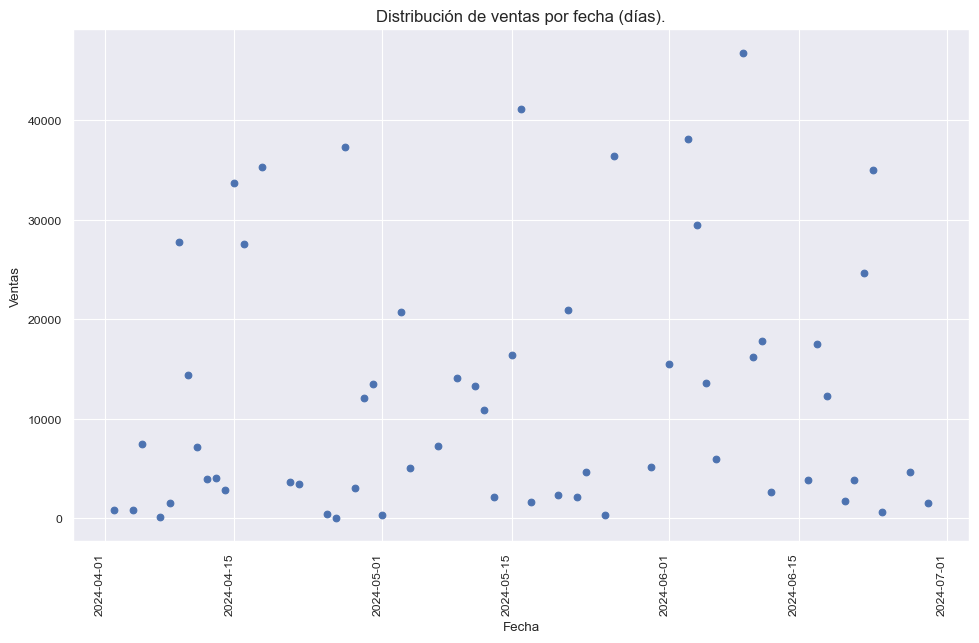

In [17]:
# Gráfica de puntos: ventas por fecha

query_04_result["order_date"] = pd.to_datetime(query_04_result["order_date"])

plt.figure(figsize=(10, 6))
plt.scatter(query_04_result["order_date"], query_04_result["cumulative_sales"], color="b", marker="o")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.title("Distribución de ventas por fecha (días).", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=90, ha="right")
plt.show()


In [18]:
# Consulta No. 5: distribución de ordenes por "status"...

query_05 = """
SELECT
status,
COUNT(status) AS status_dist
FROM query_01_db
GROUP BY status
"""

query_05_result = pd.read_sql(query_05, conexion)
query_05_result

,status,status_dist
0,delivered,105
1,pending,124
2,shipped,91


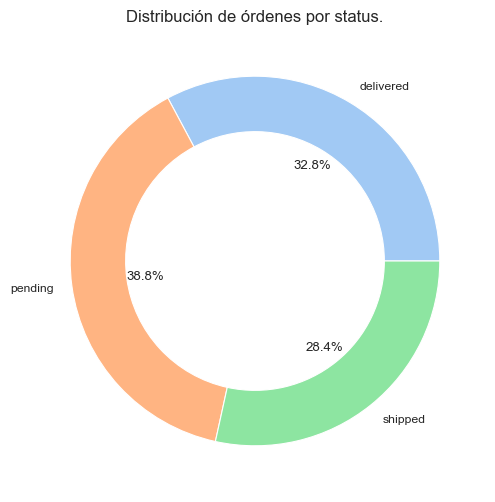

In [19]:
# Gráfica de dona: distribución de órdenes por "status"

plt.figure(figsize=(8, 6))
plt.pie(query_05_result["status_dist"], labels=query_05_result["status"], autopct="%1.1f%%", colors=sns.color_palette("pastel"), wedgeprops=dict(width=0.3))
plt.title("Distribución de órdenes por status.", fontsize=12)
plt.show()